In [1]:
import sys, os
import numpy as np
from scipy.stats import zscore
from rastermap import Rastermap, utils
from neuropop import linear_prediction

# path to paper code
sys.path.insert(0, '/github/rastermap/paper')
from loaders import (load_widefield_data, load_hippocampus_data, 
                     load_fish_data, tuning_curves_hipp)
import fig4 

# path to directory with data etc
### *** CHANGE THIS TO WHEREEVER YOU ARE DOWNLOADING THE DATA ***
root = "/media/carsen/ssd2/rastermap_paper/"
# (in this folder we have a "data" folder and a "results" folder)
os.makedirs(os.path.join(root, "data"), exist_ok=True)
os.makedirs(os.path.join(root, "results"), exist_ok=True)


### hippocampus data

We used the spiking data from Grosmark & Buszaki 2016, available [here](https://crcns.org/data-sets/hc/hc-11/about-hc-11). Specifically download the `Achilles_10252013_sessInfo.mat`.

In [ ]:
### path to mat file (SPECIFIC FOR YOUR COMPUTER)
filename = os.path.join(root, "data", "Achilles_10252013_sessInfo.mat")

# load data
bin_sec = 0.2
dat = load_hippocampus_data(filename, bin_sec=bin_sec)
spks = dat["spks"]
spks = zscore(spks, axis=1)
n_neurons, n_time = spks.shape 
pyr_cells = dat["pyr_cells"]
loc_signed = dat["loc_signed"]
loc2d = dat["loc2d"]
speed = (np.diff(loc2d, axis=0)**2).sum(axis=1)**0.5
speed = np.concatenate((np.zeros((1,)), speed), axis=0)

# compute tuning curves along linear corridor
n_pos = 15
bins = np.arange(-1, 1+1./n_pos, 1./n_pos)
tcurves = tuning_curves_hipp(spks, loc_signed, bins)

model = Rastermap(n_clusters=None, 
                  n_PCs=64, 
                  locality=0.1,   # 0.1<-include nan's, #0.05 <- interp nan's #0.25 <- remove nan's
                  time_lag_window=15,  # 15<- include nan's, #10 <- interp nan's # 20 <- remove nan's
                  symmetric=False,
                  grid_upsample=0,
                  ).fit(spks)
isort = model.isort 
cc_nodes = model.cc

np.savez(os.path.join(root, "results", "hippocampus_proc.npz"),
         spks=spks, pyr_cells=pyr_cells, speed=speed, loc2d=loc2d, tcurves=tcurves,
         isort=isort, cc_nodes=cc_nodes)
         

### widefield data

We used the widefield data from the Musall*, Kaufman* et al paper [here](https://labshare.cshl.edu/shares/library/repository/38599/Widefield/mSM43/21-Nov-2017/). Specifically download `interpVc.mat`, `Vc.mat` and `regData.mat`. Then the following code will sort the data and compute the neural prediction from the task variables and behaviors.

In [ ]:
### path to mat files (SPECIFIC FOR YOUR COMPUTER)
expname = "mSM43_21-Nov-2017"
data_path = os.path.join(root, "data/", expname)

### load data
out = load_widefield_data(data_path)
(U0, sv, Vsv, ypos, xpos, regressors, 
    behav_idx, stim_times, reward_times, stim_labels) = out


### run rastermap
model = Rastermap(n_clusters=100, locality=0.5, time_lag_window=10,
                  n_PCs=U0.shape[1]).fit(Usv = U0 * sv, 
                                                          Vsv = Vsv)

isort = model.isort 
cc_nodes = model.cc
Vsv_sub = model.Vsv

bin_size = 200
U_sn = utils.bin1d(U0[isort], bin_size=bin_size, axis=0) # bin over voxel axis
sn = U_sn @ Vsv_sub.T
sn = zscore(sn, axis=1)

### predict activity from behavior
ve, _, sn_pred, itest = linear_prediction.prediction_wrapper(regressors, sn.T, lam=1e4, delay=0)
sn_pred = sn_pred.T
itest = itest.flatten()
print(ve)
ve, _, sn_pred_beh, itest = linear_prediction.prediction_wrapper(regressors[:,behav_idx], sn.T, lam=1e4, delay=0)
itest = itest.flatten()
sn_pred_beh = sn_pred_beh.T
print(ve)

np.savez(os.path.join(root, "results", "widefield_proc.npz"),
         stim_times_0=stim_times[0], 
         stim_times_1=stim_times[1], 
         stim_times_2=stim_times[2], 
         stim_times_3=stim_times[3], 
         stim_labels=stim_labels, reward_times=reward_times, 
          sn=sn, sn_pred=sn_pred, sn_pred_beh=sn_pred_beh, 
          bin_size=bin_size, itest=itest, ypos=ypos, xpos=xpos, isort=isort)

### zebrafish data

We used a neural recording from Chen*, Mu*, Hu*, Kuan* et al 2018, specifically `subject_8` found [here](https://figshare.com/articles/dataset/Whole-brain_light-sheet_imaging_data/7272617?file=13474868). Download the zip file and unzip it (we found this works best with the tool 7zip).

In [ ]:
### folder with "subject_8" folder
data_path = os.path.join(root, "data")

spks, F, xyz, stims, swimming, eyepos = load_fish_data(data_path, subject=8)

model = Rastermap(n_clusters=100, locality=0.1, time_lag_window=5, n_PCs=200).fit(spks)
isort = model.isort 
cc_nodes = model.cc
sn = zscore(utils.bin1d(zscore(spks[isort], axis=1), bin_size=50, axis=0), axis=1)

np.savez(os.path.join(root, "results", "fish_proc.npz"),
         swimming=swimming, eyepos=eyepos, stims=stims, 
         sn=sn, xyz=xyz, isort=isort, cc_nodes=cc_nodes)

### make figure

64404.0 592
170.0 45.0


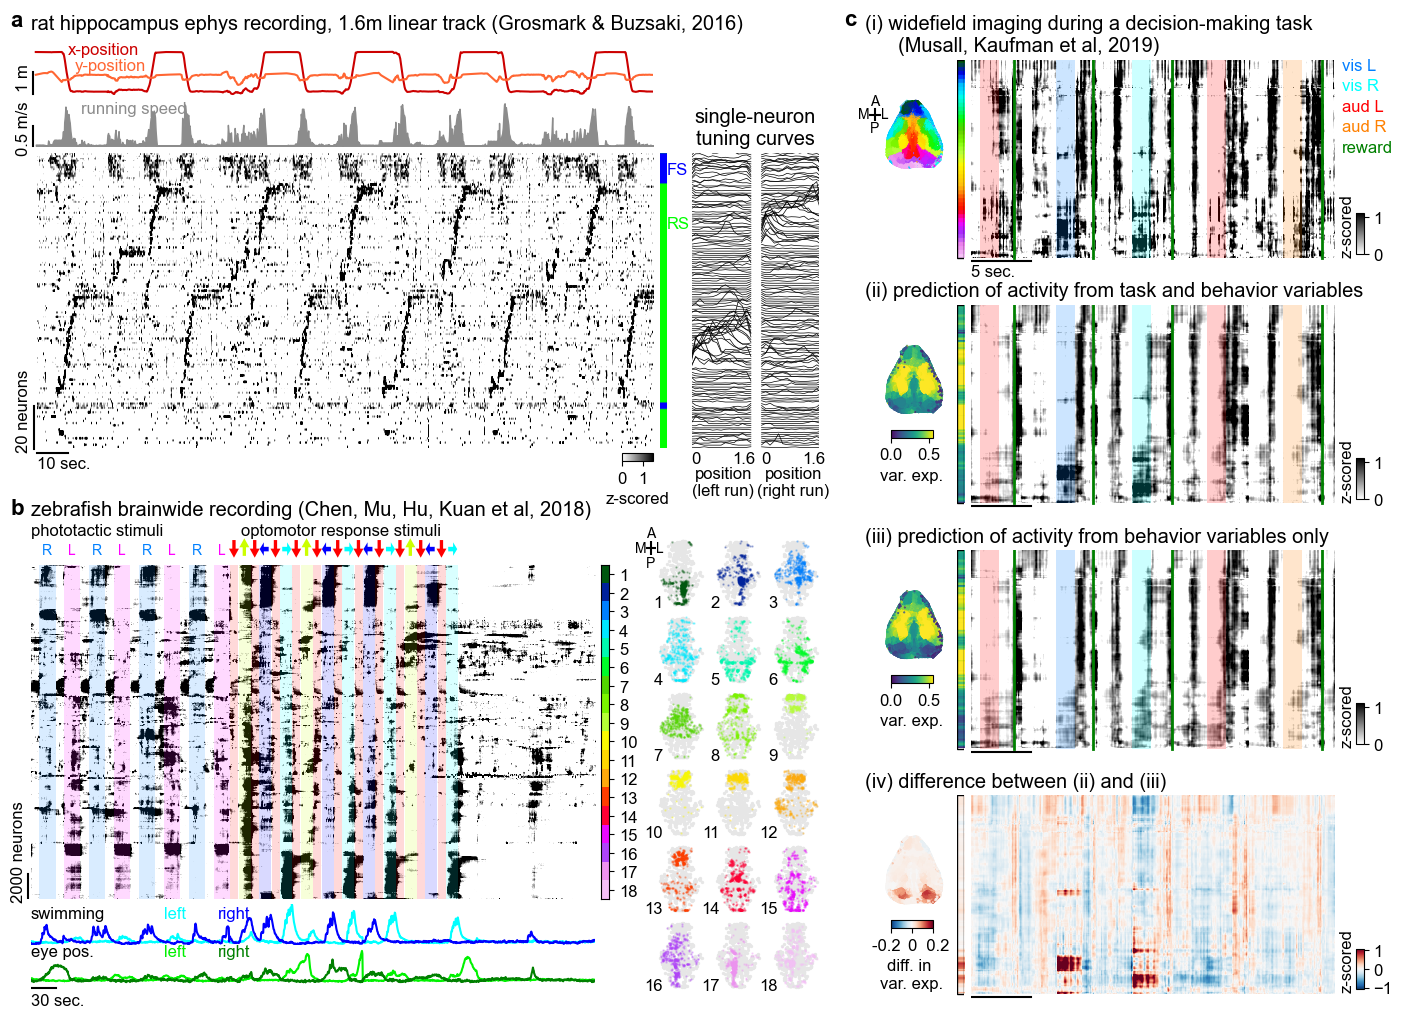

In [12]:
# root path has folder "results" with saved results
# will save figures to "figures" folder
# will ignore panels that aren't processed
import imp
imp.reload(fig4)
os.makedirs(os.path.join(root, "figures/"), exist_ok=True)
fig4.fig4(root)